## Modeling Exercises

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# wrangle
import acquire as a
import prepare as p

# working with dates
from datetime import datetime

# to evaluated performance using rmse
from sklearn.metrics import mean_squared_error
from math import sqrt 

# for tsa 
import statsmodels.api as sm

# holt's linear trend model. 
from statsmodels.tsa.api import Holt, ExponentialSmoothing

import statsmodels.api as sm

In [2]:
# Get data from the URL
#url = "https://ds.codeup.com/saas.csv"

#df = pd.read_csv(url)
#df.head()


In [3]:
#Functions from class to help

In [4]:
#These functions have been amended to have a train/test split without validate
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(test[target_var], yhat_df[target_var])), 0)
    return rmse

In [5]:
#These functions have been amended to have a train/test split without validate
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(test[target_var], label='Test', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [6]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


In [7]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Get the Data

In [8]:
#Get data from the local csv
df = pd.read_csv('saas.csv')

In [9]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


### Prep the Data

In [10]:
#Rename the columns so they dont have capitalization
df = df.rename(columns = {'Month_Invoiced':'month_invoiced', 'Customer_Id':'customer_id',
                              'Invoice_Id':'invoice_id', 'Subscription_Type':'subscription_type',
                    'Amount':'amount'})

# Reassign the month invoiced column to be a datetime type
df.month_invoiced = pd.to_datetime(df.month_invoiced)

# Set the index as that date and then sort index (by the date)
df = df.set_index("month_invoiced").sort_index()

In [11]:
df.index
#4 years of data by month

DatetimeIndex(['2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
               '2014-01-31', '2014-01-31', '2014-01-31', '2014-01-31',
               '2014-01-31', '2014-01-31',
               ...
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31', '2017-12-31', '2017-12-31',
               '2017-12-31', '2017-12-31'],
              dtype='datetime64[ns]', name='month_invoiced', length=790458, freq=None)

In [12]:
#Check the data out
df.head()

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0


In [13]:
#Look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 790458 entries, 2014-01-31 to 2017-12-31
Data columns (total 4 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   customer_id        790458 non-null  int64  
 1   invoice_id         790458 non-null  int64  
 2   subscription_type  790458 non-null  float64
 3   amount             790458 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 30.2 MB


In [14]:
#Check for nulls (there are none)
df.isnull().sum()

customer_id          0
invoice_id           0
subscription_type    0
amount               0
dtype: int64

In [15]:
#Sum the amount 
#Subscription type is * 5 amount

### Resample by month

In [16]:
df_resampled = df.resample('M')[['amount']].sum()
df_resampled.head()

,amount
month_invoiced,
2014-01-31,35850.0
2014-02-28,37190.0
2014-03-31,38295.0
2014-04-30,39255.0
2014-05-31,40355.0


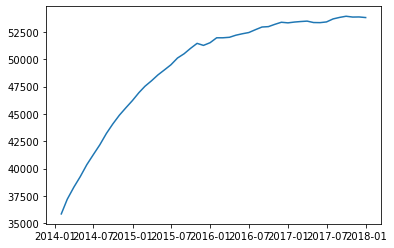

In [17]:
plt.plot(df_resampled.index, df_resampled.amount)

### 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [18]:
#Resampled shown above, with aggregation

In [19]:
#Split the Data
#Set train size to by 70 percent of total
train_size = int(round(df_resampled.shape[0] * 0.7))
train_size

34

In [20]:
# set test size to be 30% of total 
test_size = int(round(df_resampled.shape[0] * 0.3))
test_size

14

In [21]:
#Check all data is there
len(df_resampled) == train_size + test_size

True

In [22]:
# test will go from 34 to 34+13
train_end_index = train_size + test_size
train_end_index

48

In [23]:
# train will go from 0 to 33
train = df_resampled[:train_size]

In [24]:
# test will go from 33 to 48
test = df_resampled[train_size:train_end_index]

In [25]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 2014-01-31 to 2016-10-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amount  34 non-null     float64
dtypes: float64(1)
memory usage: 544.0 bytes
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14 entries, 2016-11-30 to 2017-12-31
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   amount  14 non-null     float64
dtypes: float64(1)
memory usage: 224.0 bytes


(None, None)

In [26]:
train.tail()

,amount
month_invoiced,
2016-06-30,52435.0
2016-07-31,52695.0
2016-08-31,52940.0
2016-09-30,52975.0
2016-10-31,53190.0


In [27]:
test.head()

,amount
month_invoiced,
2016-11-30,53375.0
2016-12-31,53320.0
2017-01-31,53395.0
2017-02-28,53440.0
2017-03-31,53480.0


In [28]:
#Good to go

### 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
* Simple Average
* Moving Average
* Holt's Linear Trend Model
* Based on previous year/month/etc., this is up to you.

### Simple Average

In [29]:
#Establish the value of the prediction we will make
# compute simple average
avg_amount = round(train['amount'].mean(), 2)
avg_amount

47597.21

In [30]:
#Apply predictions to our observations
def make_predictions(amount=None):
    yhat_df = pd.DataFrame({'amount': [amount]},
                          index=test.index)
    return yhat_df

In [31]:
yhat_df = make_predictions(avg_amount)
yhat_df.head()

,amount
month_invoiced,
2016-11-30,47597.21
2016-12-31,47597.21
2017-01-31,47597.21
2017-02-28,47597.21
2017-03-31,47597.21


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

amount -- RMSE: 5982


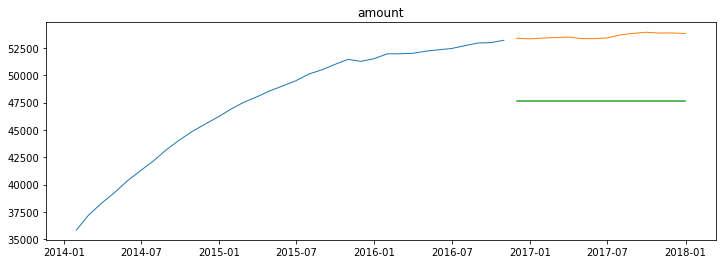

In [32]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

* Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [33]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,simple_average,amount,5982.0


### Moving Average

In [34]:
#Using a 90 day moving forecast
# demonstrate that the mean of the first 90 days 
# is equal to rolling(90) on day 90

print(train['amount'].rolling(3).mean())

month_invoiced
2014-01-31             NaN
2014-02-28             NaN
2014-03-31    37111.666667
2014-04-30    38246.666667
2014-05-31    39301.666667
2014-06-30    40288.333333
2014-07-31    41260.000000
2014-08-31    42211.666667
2014-09-30    43151.666667
2014-10-31    44055.000000
2014-11-30    44833.333333
2014-12-31    45545.000000
2015-01-31    46233.333333
2015-02-28    46891.666667
2015-03-31    47496.666667
2015-04-30    48035.000000
2015-05-31    48536.666667
2015-06-30    49023.333333
2015-07-31    49538.333333
2015-08-31    50028.333333
2015-09-30    50528.333333
2015-10-31    50975.000000
2015-11-30    51230.000000
2015-12-31    51403.333333
2016-01-31    51573.333333
2016-02-29    51805.000000
2016-03-31    51970.000000
2016-04-30    52048.333333
2016-05-31    52171.666667
2016-06-30    52316.666667
2016-07-31    52485.000000
2016-08-31    52690.000000
2016-09-30    52870.000000
2016-10-31    53035.000000
Freq: M, Name: amount, dtype: float64


In [35]:
period=3
train['amount'].rolling(period).mean()[-1]

53035.0

In [36]:
period = 3 

# take 90 day rolling average, then take the last element and that will the one that propogates 
# forward as our prediction. 
rolling_amount = round(train['amount'].rolling(period).mean()[-1], 2)
print(rolling_amount)

53035.0


#### Make Predictions

In [37]:
yhat_df = make_predictions(rolling_amount)
yhat_df.head()

,amount
month_invoiced,
2016-11-30,53035.0
2016-12-31,53035.0
2017-01-31,53035.0
2017-02-28,53035.0
2017-03-31,53035.0


**Plot Actual vs. Predicted Values**

* Now, let's plot and evaluate the performance of our time series model using **Moving Average**

amount -- RMSE: 584


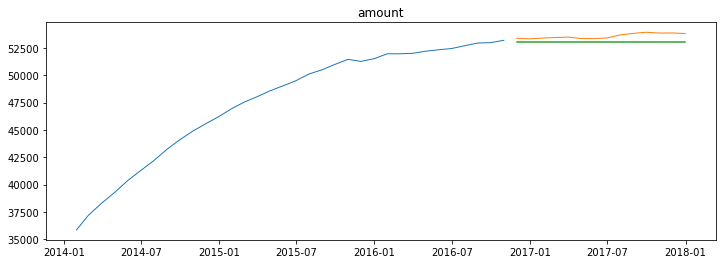

In [38]:
for col in train.columns:
    plot_and_eval(col)

#### **Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [39]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '90d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,simple_average,amount,5982.0
1,90d_moving_avg,amount,584.0


Let's try out several other values for periods:

In [40]:
periods = [1, 4, 6, 12]

for p in periods: 
    rolling_amount = round(train['amount'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(rolling_amount)
    model_type = str(p) + '_month_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [41]:
rolling_amount

52285.42

In [42]:
eval_df

,model_type,target_var,rmse
0,simple_average,amount,5982.0
1,90d_moving_avg,amount,584.0
2,1_month_moving_avg,amount,445.0
3,4_month_moving_avg,amount,664.0
4,6_month_moving_avg,amount,845.0
5,12_month_moving_avg,amount,1309.0


In [43]:
min_items_rmse = eval_df[eval_df.target_var == 'amount']['rmse'].min()

In [44]:
min_items_rmse

445.0

In [45]:
# 1 Month moving average is best

In [46]:
eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
2,1_month_moving_avg,amount,445.0


In [47]:
min_dollars_rmse = eval_df[eval_df.target_var == 'amount']['rmse'].min()

eval_df[eval_df.rmse == min_dollars_rmse]

,model_type,target_var,rmse
2,1_month_moving_avg,amount,445.0


### Holt's Linear Trend

amount 



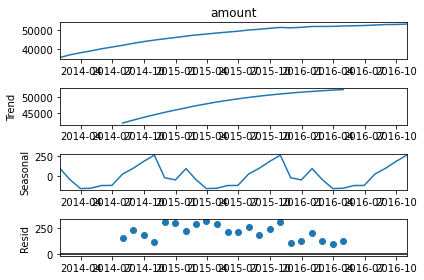

In [48]:
print(col, '\n')
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
plt.show()

In [49]:
col = 'amount' 
# create our Holt's Object
model = Holt(train[col], exponential=False, damped=True)

In [50]:
# fit the holt's object
model = model.fit(optimized=True) #Optimiized true means it will determine alpha and beta that will have the lowest RMSE

In [51]:
yhat_items = model.predict(start = test.index[0],
                              end = test.index[-1])

In [52]:
test.index[-1]

Timestamp('2017-12-31 00:00:00', freq='M')

In [53]:
test.shape

(14, 1)

In [54]:
yhat_items

2016-11-30    53341.029681
2016-12-31    53499.657056
2017-01-31    53656.810818
2017-02-28    53812.504656
2017-03-31    53966.752132
2017-04-30    54119.566684
2017-05-31    54270.961621
2017-06-30    54420.950134
2017-07-31    54569.545285
2017-08-31    54716.760021
2017-09-30    54862.607164
2017-10-31    55007.099419
2017-11-30    55150.249374
2017-12-31    55292.069496
Freq: M, dtype: float64

In [55]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_items = model.predict(start = test.index[0],
                              end = test.index[-1])
    yhat_df[col] = round(yhat_items, 2)

In [56]:
yhat_df

,amount
month_invoiced,
2016-11-30,53341.03
2016-12-31,53499.66
2017-01-31,53656.81
2017-02-28,53812.50
2017-03-31,53966.75
2017-04-30,54119.57
2017-05-31,54270.96
2017-06-30,54420.95
2017-07-31,54569.55


In [57]:
test

,amount
month_invoiced,
2016-11-30,53375.0
2016-12-31,53320.0
2017-01-31,53395.0
2017-02-28,53440.0
2017-03-31,53480.0
2017-04-30,53350.0
2017-05-31,53340.0
2017-06-30,53405.0
2017-07-31,53680.0


In [58]:
yhat_items

2016-11-30    53341.029681
2016-12-31    53499.657056
2017-01-31    53656.810818
2017-02-28    53812.504656
2017-03-31    53966.752132
2017-04-30    54119.566684
2017-05-31    54270.961621
2017-06-30    54420.950134
2017-07-31    54569.545285
2017-08-31    54716.760021
2017-09-30    54862.607164
2017-10-31    55007.099419
2017-11-30    55150.249374
2017-12-31    55292.069496
Freq: M, dtype: float64

**Plot Actual vs. Predicted Values**

amount -- RMSE: 873


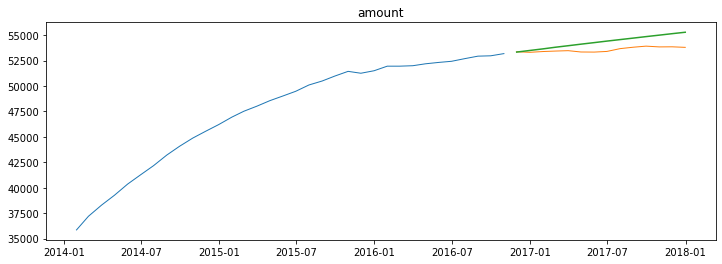

In [59]:
for col in train.columns:
    plot_and_eval(target_var = col)

**Evaluate**

In [60]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [61]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
2,1_month_moving_avg,amount,445.0
1,90d_moving_avg,amount,584.0
3,4_month_moving_avg,amount,664.0
4,6_month_moving_avg,amount,845.0
6,holts_optimized,amount,873.0
5,12_month_moving_avg,amount,1309.0
0,simple_average,amount,5982.0


### Review

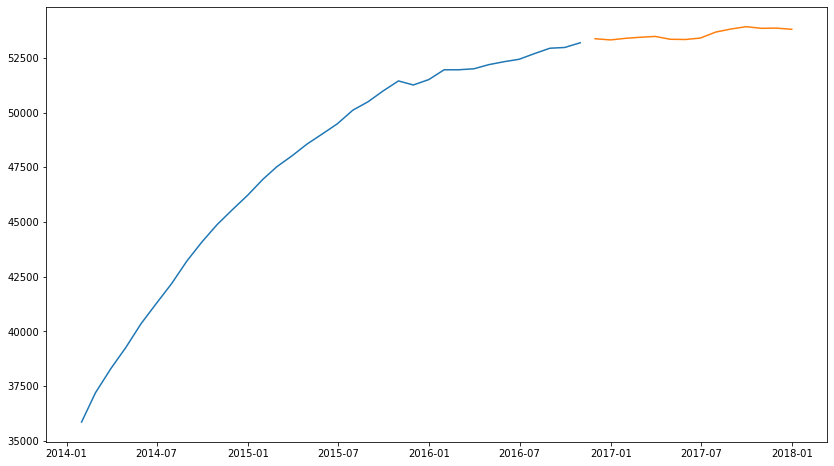

In [62]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(test[col])